# Evaluating experiments

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import train
import kernels

from jax.experimental import optimizers

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
def get_data(rundir):
    """Take directory with run results and return a Pandas DataFrame with the relevant hparams plus metrics.
    Returns:
    * frame: a pandas dataframe with config hparams and metrics
    * data: a list of dicts with data collected during runs"""
    cfgs = []
    data = []
    metrics = []
    for logdir in os.listdir(rundir):
        configfile, datafile, metricfile = [rundir + logdir + f for f in ["/config", "/data", "/metrics"]]
        with open(configfile, "r") as f:
            cfgs.append(json.load(f))
        with open(datafile, "r") as f:
            data.append(json.load(f))
        with open(metricfile, "r") as f:
            metrics.append(json.load(f))
     
    # process data
    cfgs = [utils.flatten_dict(c) for c in cfgs]
    for c in cfgs:
        if len(c["optimizer_svgd_args"]) == 1:
            c["optimizer_svgd_args"] = c["optimizer_svgd_args"][0]
        if len(c["optimizer_ksd_args"]) == 1:
            c["optimizer_ksd_args"] = c["optimizer_ksd_args"][0]        
    
    frame = pd.DataFrame(cfgs)
    frame["KSD Squared"] = metrics
    frame.rename(columns={"optimizer_svgd_args": "lr svgd", "optimizer_ksd_args": "lr ksd"}, inplace=True)
    
    return frame, data

In [3]:
rundir = "../runs/test1/"
hparams = ["KSD Squared", "layers", "lr svgd"]
frame, data = get_data(rundir)
f = frame[hparams]
f

,KSD Squared,layers,lr svgd
0,0.210310,"[32, 32, 32]",1.0
1,0.036900,"[32, 32, 32]",5.0
2,0.117035,"[32, 32, 32, 2]",1.0
3,0.119718,"[32, 32, 32, 2]",5.0
4,0.112732,"[32, 32, 2]",1.0
5,2.243593,"[32, 32, 2]",0.1
6,0.001279,"[32, 32]",5.0
7,2.134866,"[32, 2]",0.1
8,0.171277,"[32, 2]",1.0
9,0.208072,"[32, 32]",1.0


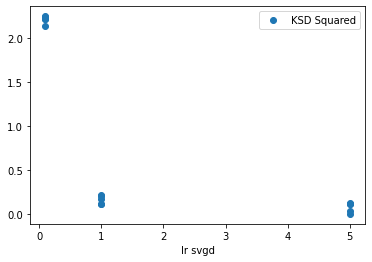

In [4]:
f.plot(x="lr svgd", y="KSD Squared", style="o")

In [5]:
f = f[f["lr svgd"] != 0.1]

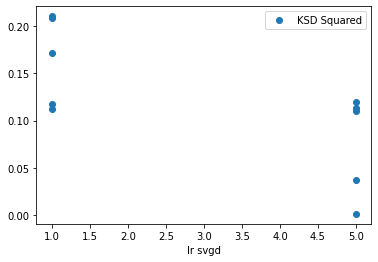

In [6]:
f.plot(x="lr svgd", y="KSD Squared", style="o")

In [7]:
f = f[f["lr svgd"] != 1.0]

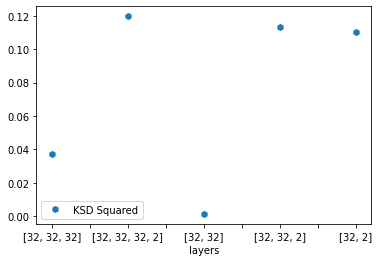

In [8]:
f.plot(x="layers", y="KSD Squared", style="h")

In [9]:
f

,KSD Squared,layers,lr svgd
1,0.036900,"[32, 32, 32]",5.0
3,0.119718,"[32, 32, 32, 2]",5.0
6,0.001279,"[32, 32]",5.0
11,0.113004,"[32, 32, 2]",5.0
12,0.110252,"[32, 2]",5.0
